Need to switch to python 3.10 and use the causica conda env

Something like :

<pre>
conda create -n causica python=3.10
pyenv install 3.10 
pyenv local 3.10
conda activate causica
jupyter-lab
</pre>

In [1]:
import sys
print(sys.version)

3.10.18 (main, Feb  6 2026, 10:20:28) [Clang 17.0.0 (clang-1700.6.3.2)]


In [2]:
%pip install causica

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install gcastle

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Example of how to inspect the available classes in your current environment
import causica.functional_relationships
print(dir(causica.functional_relationships))

['DECIEmbedFunctionalRelationships', 'DoFunctionalRelationships', 'FunctionalRelationships', 'HeteroscedasticRFFFunctionalRelationships', 'LinearFunctionalRelationships', 'RFFFunctionalRelationships', 'TemporalEmbedFunctionalRelationships', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'create_do_functional_relationship', 'deci_functional_relationships', 'do_functional_relationships', 'functional_relationships', 'heteroscedastic_rff_functional_relationships', 'linear_functional_relationships', 'rff_functional_relationships', 'temporal_functional_relationships']


In [5]:
from dataclasses import dataclass

import numpy as np
import networkx as nx

import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from tensordict import TensorDict

from castle.datasets import DAG, IIDSimulation 
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

import causica.distributions as cd
from causica.sem.sem_distribution import SEMDistributionModule

from causica.functional_relationships import DECIEmbedFunctionalRelationships
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig
from causica.graph.dag_constraint import calculate_dagness

from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.tensordict_utils import tensordict_shapes

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [6]:
# Set device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

device = 'cpu'
device

'cpu'

In [7]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 14


In [8]:
# Set random seed
SEED = 11
np.random.seed(SEED)
pl.seed_everything(SEED)  

Seed set to 11


11

## DECI

### Data & configuration

In [9]:
nx.__version__

'3.4.2'

In [10]:
# Generate a scale-free adjacency matrix
adj_matrix = DAG.scale_free(
    n_nodes=4,
    n_edges=6,
    seed=SEED
)

# Generate the simulation
dataset = IIDSimulation(
    W=adj_matrix, 
    n=5000, 
    method='nonlinear', 
    sem_type='mim'
)

2026-02-06 11:07:04,351 - /Users/oneshin/.pyenv/versions/3.10.18/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


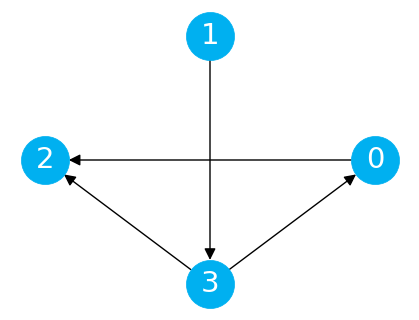

In [11]:
# Plot the graph
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(4, 3))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [12]:
# Training config
@dataclass(frozen=True)
class TrainingConfig:
    noise_dist=cd.ContinuousNoiseDist.SPLINE
    batch_size=512
    max_epoch=500
    gumbel_temp=0.25
    averaging_period=10
    prior_sparsity_lambda=5.0
    init_rho=1.0
    init_alpha=0.0
        
training_config = TrainingConfig()
auglag_config = AugLagLRConfig()

In [13]:
# Cast data to torch tensors
data_tensors = {}

for i in range(dataset.X.shape[1]):
    data_tensors[f'x{i}'] = torch.tensor(dataset.X[:, i].reshape(-1, 1))
    
dataset_train = TensorDict(data_tensors, torch.Size([dataset.X.shape[0]]))
    
# Move the entire dataset to the device (for big datasets move to device by batch within training loop)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

# Create loader
dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

dataset_train

TensorDict(
    fields={
        x0: Tensor(shape=torch.Size([5000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x1: Tensor(shape=torch.Size([5000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x2: Tensor(shape=torch.Size([5000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x3: Tensor(shape=torch.Size([5000, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([5000]),
    device=None,
    is_shared=False)

### Expert knowledge

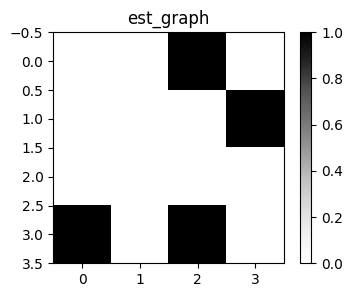

In [14]:
# Plot the true adj matrix
plt.style.use('default')
GraphDAG(adj_matrix)
plt.show()

In [15]:
# Encode our strong belief about the existence of the edge (3, 0) 
# And lack of existence of edge (0, 3)
expert_matrix = torch.tensor(np.zeros(adj_matrix.shape))

# Encode the edge knowledge
expert_matrix[3, 0] = 1.

# Create a relevancew mask
relevance_mask = expert_matrix.clone()
relevance_mask[0, 3] = 1.

# Create a confidence matrix
confidence_matrix = relevance_mask.clone()

In [16]:
# Encapsulate everything within the expert knowledge container
expert_knowledge = cd.ExpertGraphContainer(
    dag=expert_matrix,
    mask=relevance_mask,
    confidence=confidence_matrix,
    scale=5.
)

/Users/oneshin/.pyenv/versions/3.10.18/lib/python3.10/site-packages/causica/distributions/adjacency/gibbs_dag_prior.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("confidence", torch.tensor(confidence, dtype=torch.float))


In [17]:
num_nodes = len(dataset_train.keys())

# Define the prior
prior = cd.GibbsDAGPrior(
    num_nodes=num_nodes, 
    sparsity_lambda=training_config.prior_sparsity_lambda,
    expert_graph_container=expert_knowledge
)

In [18]:
# Define the adjaceny module
adjacency_dist = cd.ENCOAdjacencyDistributionModule(num_nodes)

#Define the functional module
icgnn = DECIEmbedFunctionalRelationships(
    shapes=tensordict_shapes(dataset_train),
    embedding_size=8,
    out_dim_g=8,
    num_layers_g=2,
    num_layers_zeta=2,
)

# Define the noise module
types_dict = {var_name: VariableTypeEnum.CONTINUOUS for var_name in dataset_train.keys()}

noise_submodules = cd.create_noise_modules(
    shapes=tensordict_shapes(dataset_train), 
    types=types_dict, 
    continuous_noise_dist=training_config.noise_dist
)

noise_module = cd.JointNoiseModule(noise_submodules)

In [19]:
noise_submodules

{'x0': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x1': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x2': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x3': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 )}

In [20]:
?SEMDistributionModule

Init signature:
SEMDistributionModule(
    adjacency_module: causica.distributions.distribution_module.DistributionModule[causica.distributions.adjacency.adjacency_distributions.AdjacencyDistribution],
    functional_relationships: causica.functional_relationships.functional_relationships.FunctionalRelationships,
    noise_module: causica.distributions.noise.joint.JointNoiseModule,
)
Docstring:      Represents a SEMDistribution with learnable parameters.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/.pyenv/versions/3.10.18/lib/python3.10/site-packages/causica/sem/sem_distribution.py
Type:           type
Subclasses:     

In [21]:
# Combine all SEM modules
sem_module = SEMDistributionModule(
    adjacency_module=adjacency_dist, 
    functional_relationships=icgnn, 
    noise_module=noise_module)

sem_module.to(device)

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): DECIEmbedFunctionalRelationships(
    (nn): DECIEmbedNN(
      (l): Sequential(
        (0): Sequential(
          (0): Linear(in_features=12, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64, out_features=64, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=64, out_features=8, bias=True)
      )
      (zeta): Sequential(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((64,), ep

In [22]:
modules = {
    "functional_relationships": sem_module.functional_relationships,  # Changed from "icgnn"
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}

parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

# Define the optimizer
optimizer = torch.optim.Adam(parameter_list)


In [23]:
#modules = {
#    "icgnn": sem_module.functional_relationships,
#    "vardist": sem_module.adjacency_module,
#    "noise_dist": sem_module.noise_module,
#}

#parameter_list = [
#    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
#    for name, module in modules.items()
#]

## Define the optimizer
#optimizer = torch.optim.Adam(parameter_list)

In [24]:
# Define the augmented Lagrangian loss objects
scheduler = AugLagLR(config=auglag_config)

auglag_loss = AugLagLossCalculator(
    init_alpha=training_config.init_alpha, 
    init_rho=training_config.init_rho
)

In [25]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

epoch:0 loss:8.1066 nll:8.107 dagness:0.00000 num_edges:0 alpha:0 rho:1 step:0|1 num_lr_updates:0


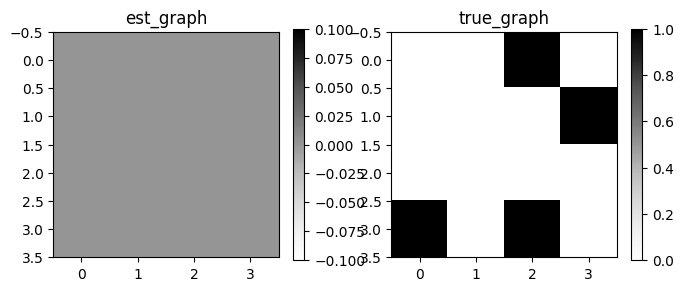

epoch:10 loss:6.3702 nll:6.3658 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:0|101 num_lr_updates:0


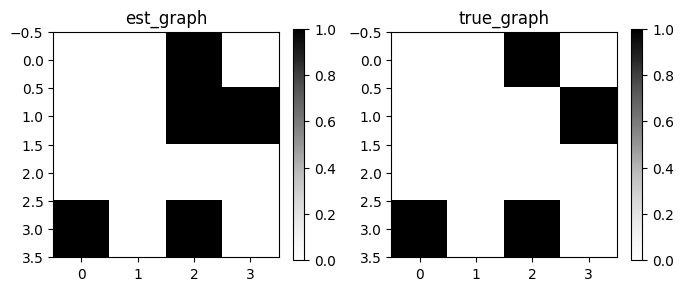

epoch:20 loss:5.8378 nll:5.8313 dagness:2.93461 num_edges:7 alpha:0 rho:1 step:0|201 num_lr_updates:0


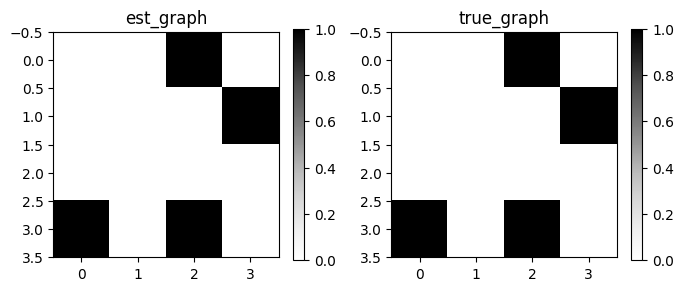

epoch:30 loss:5.9741 nll:5.9676 dagness:2.93461 num_edges:7 alpha:0 rho:1 step:0|301 num_lr_updates:0


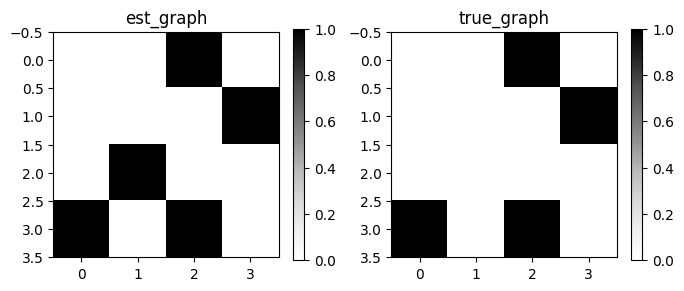

epoch:40 loss:5.642 nll:5.6374 dagness:0.50417 num_edges:5 alpha:0 rho:1 step:0|401 num_lr_updates:0


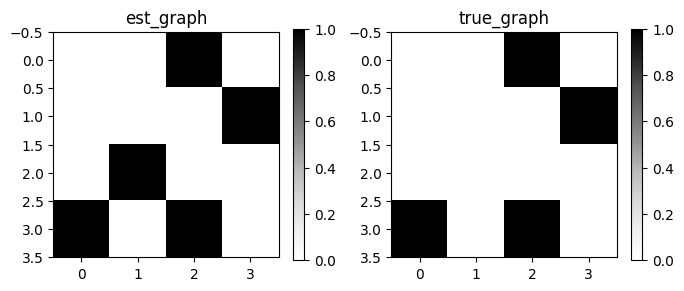

epoch:50 loss:5.6679 nll:5.6633 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|501 num_lr_updates:0


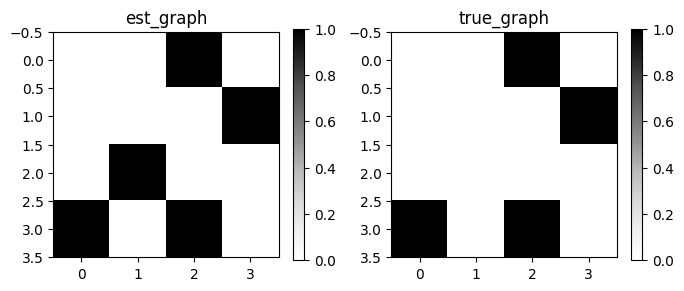

epoch:60 loss:5.6514 nll:5.6468 dagness:0.00000 num_edges:5 alpha:0 rho:1 step:0|601 num_lr_updates:0


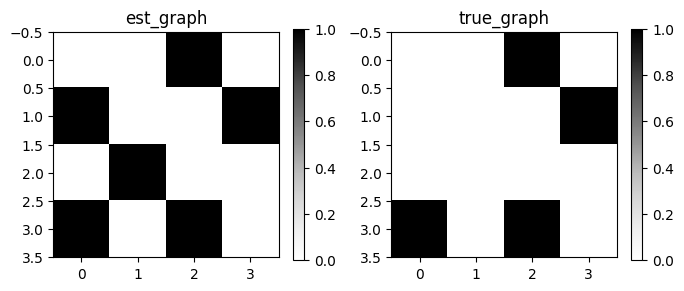

epoch:70 loss:5.7233 nll:5.7176 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|701 num_lr_updates:0


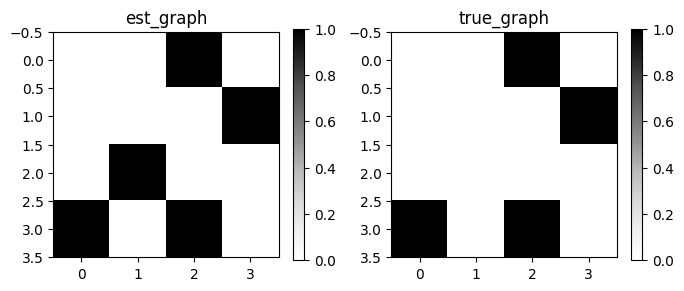

epoch:80 loss:5.7933 nll:5.7886 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|801 num_lr_updates:0


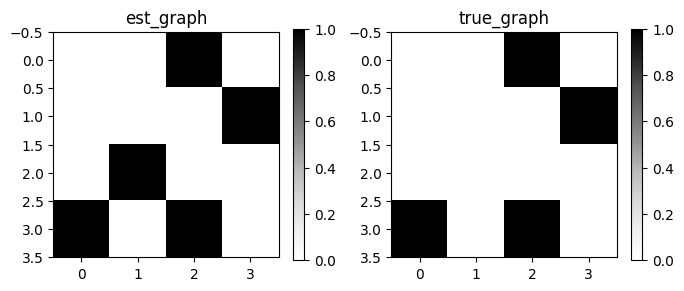

epoch:90 loss:6.0867 nll:6.083 dagness:0.50417 num_edges:4 alpha:0 rho:1 step:0|901 num_lr_updates:0


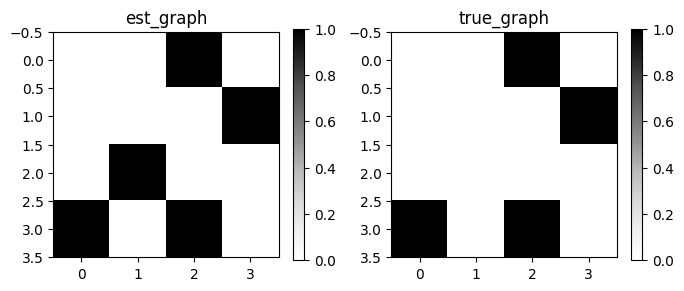

epoch:100 loss:5.6117 nll:5.607 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1001 num_lr_updates:0


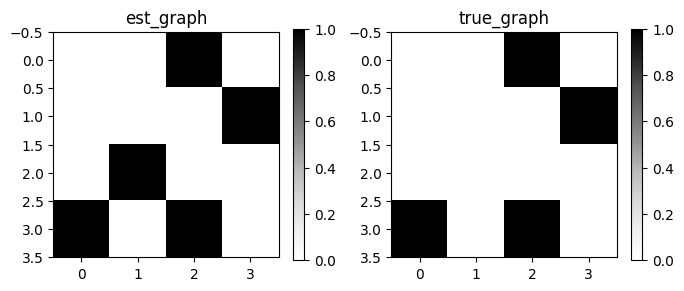

epoch:110 loss:5.7442 nll:5.7395 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1101 num_lr_updates:0


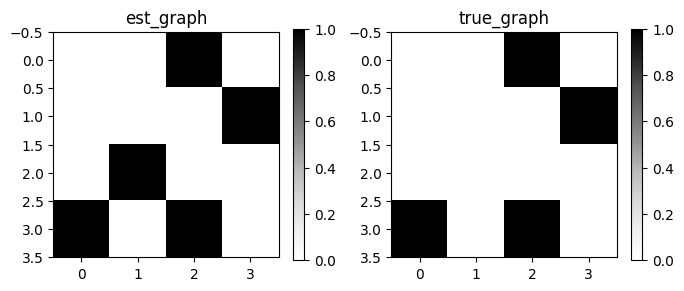

epoch:120 loss:5.6352 nll:5.6304 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1201 num_lr_updates:0


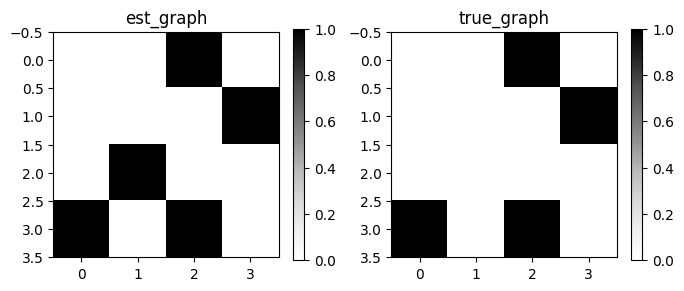

epoch:130 loss:5.7064 nll:5.7016 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1301 num_lr_updates:0


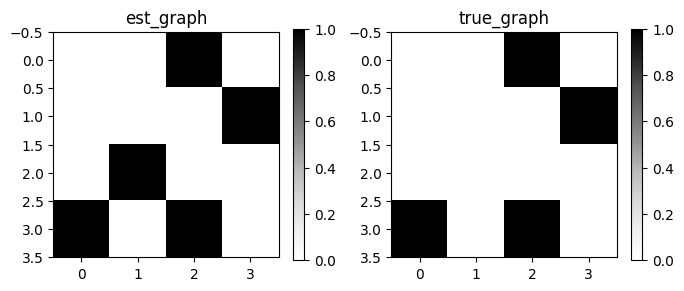

epoch:140 loss:5.6932 nll:5.6884 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1401 num_lr_updates:0


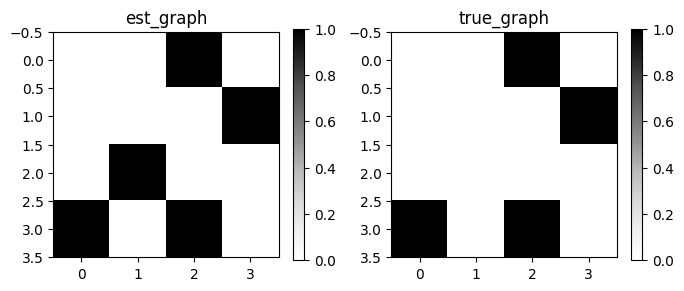

epoch:150 loss:5.6762 nll:5.6714 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1501 num_lr_updates:1


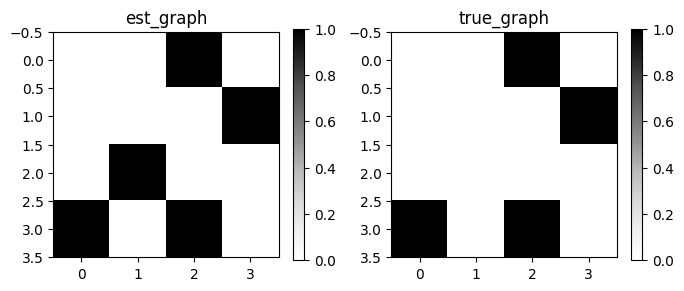

epoch:160 loss:5.6865 nll:5.6806 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|1601 num_lr_updates:1


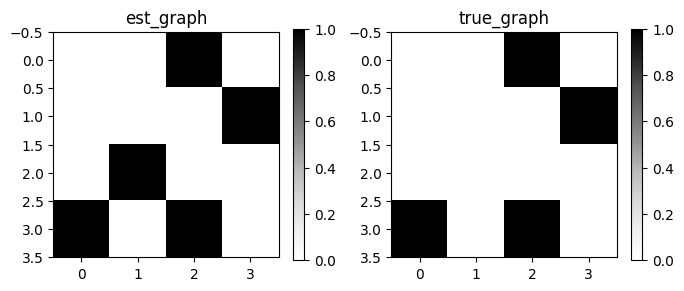

epoch:170 loss:5.5899 nll:5.5851 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1701 num_lr_updates:1


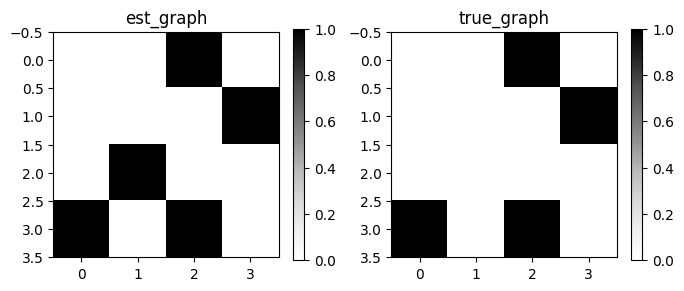

epoch:180 loss:5.5711 nll:5.5662 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1801 num_lr_updates:1


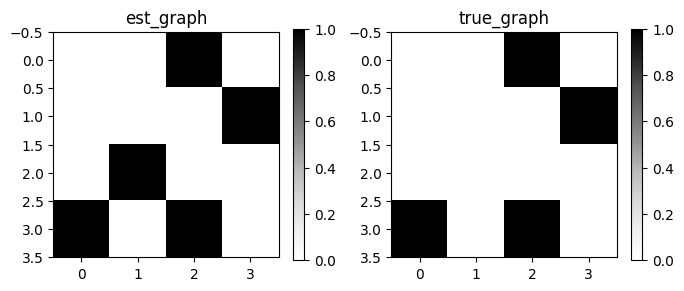

epoch:190 loss:5.6434 nll:5.6385 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|1901 num_lr_updates:1


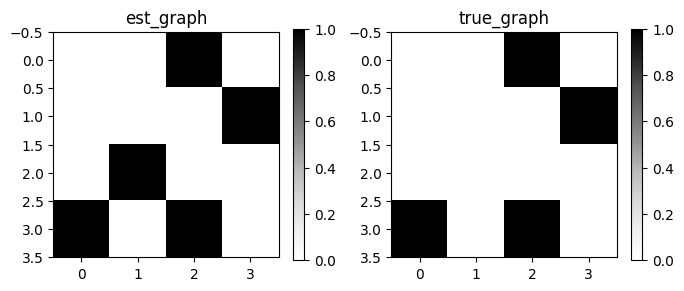

epoch:200 loss:5.7368 nll:5.731 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|2001 num_lr_updates:1


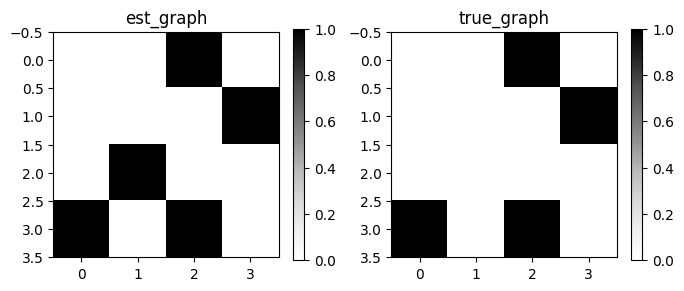

epoch:210 loss:5.6587 nll:5.6538 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|2101 num_lr_updates:1


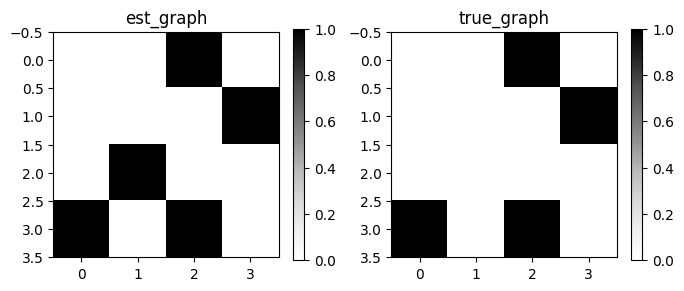

epoch:220 loss:5.6301 nll:5.6243 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|2201 num_lr_updates:1


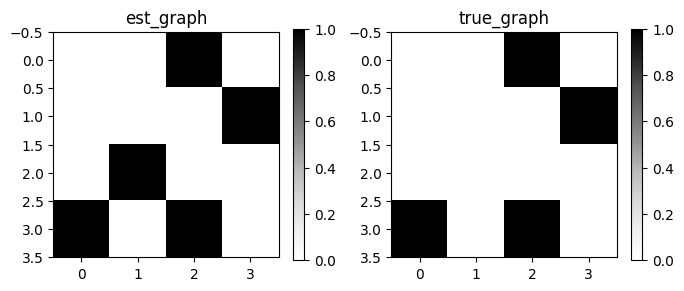

epoch:230 loss:5.6066 nll:5.6017 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|2301 num_lr_updates:2


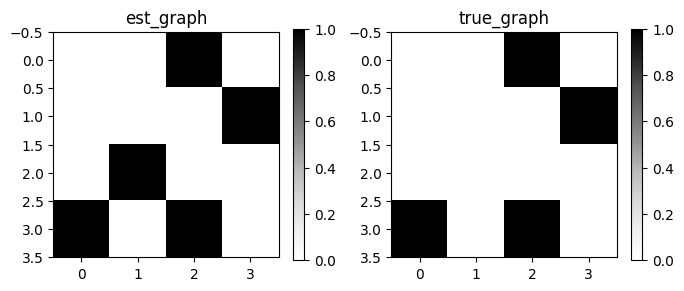

epoch:240 loss:5.6328 nll:5.628 dagness:0.67233 num_edges:5 alpha:0 rho:1 step:0|2401 num_lr_updates:2


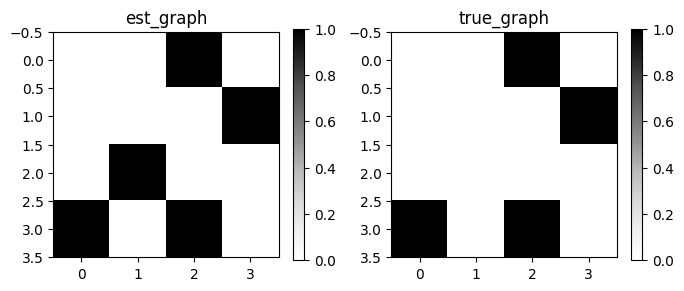

epoch:250 loss:5.575 nll:5.5692 dagness:1.18629 num_edges:6 alpha:0 rho:1 step:0|2501 num_lr_updates:2


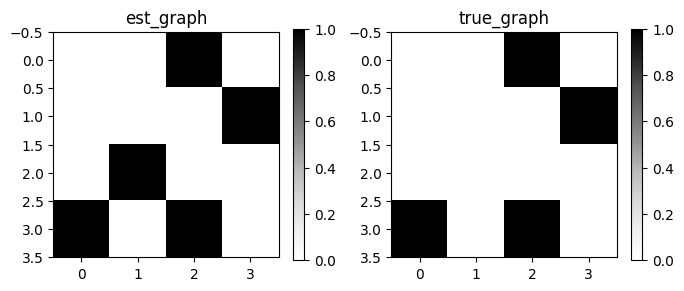

Updating alpha to: 0.672332763671875
epoch:260 loss:5.5882 nll:5.5822 dagness:1.18629 num_edges:6 alpha:0.67233 rho:1 step:1|77 num_lr_updates:0


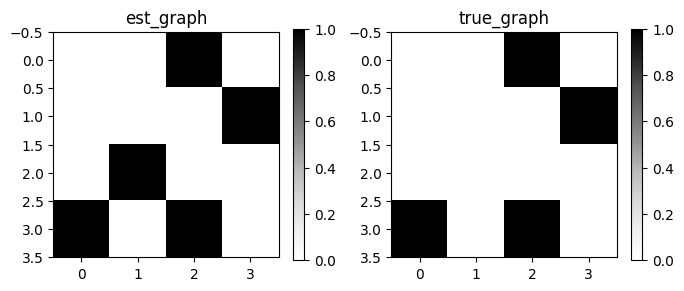

epoch:270 loss:5.6265 nll:5.6205 dagness:1.18629 num_edges:6 alpha:0.67233 rho:1 step:1|177 num_lr_updates:0


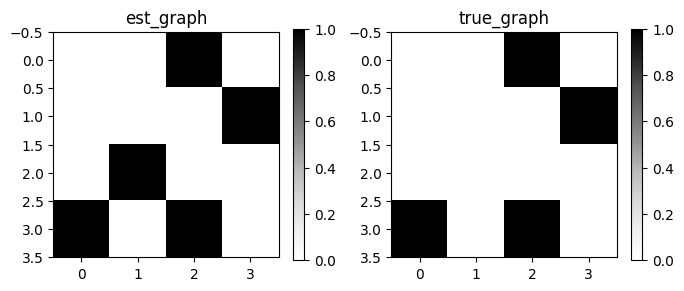

epoch:280 loss:5.8285 nll:5.8234 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|277 num_lr_updates:0


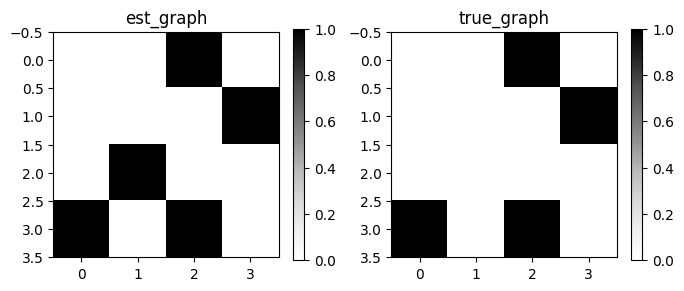

epoch:290 loss:5.6474 nll:5.6414 dagness:1.18629 num_edges:6 alpha:0.67233 rho:1 step:1|377 num_lr_updates:0


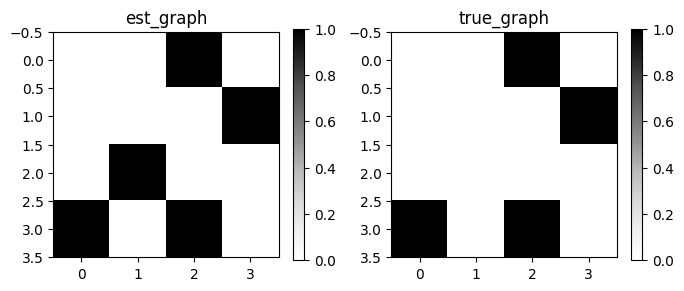

epoch:300 loss:5.7169 nll:5.7119 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|477 num_lr_updates:0


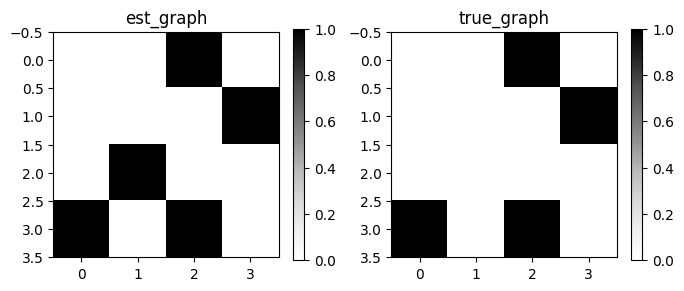

epoch:310 loss:5.6227 nll:5.6177 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|577 num_lr_updates:1


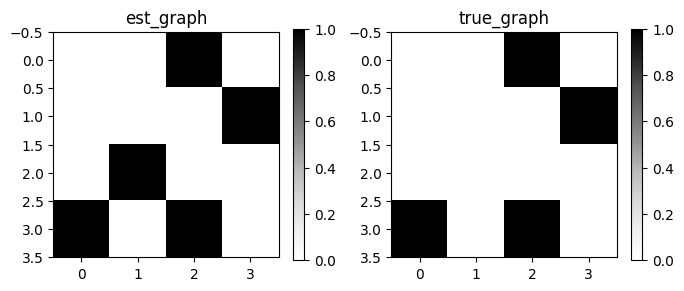

epoch:320 loss:5.6588 nll:5.6527 dagness:1.18629 num_edges:6 alpha:0.67233 rho:1 step:1|677 num_lr_updates:1


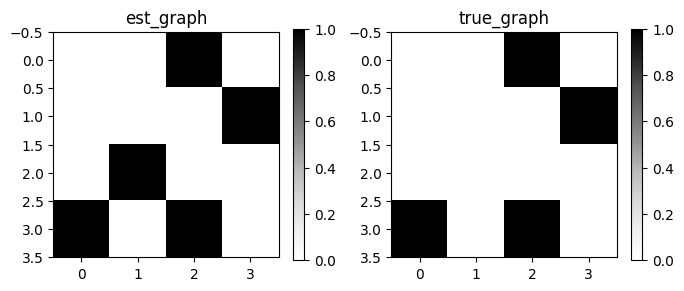

epoch:330 loss:5.6452 nll:5.6402 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|777 num_lr_updates:1


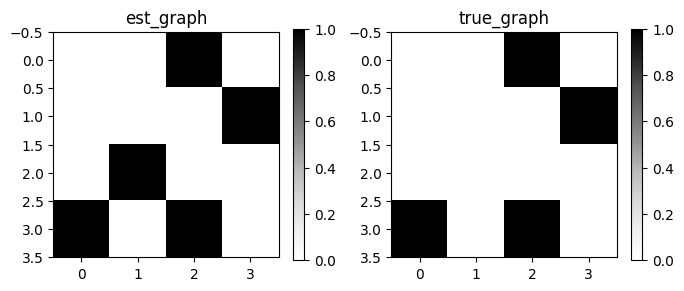

epoch:340 loss:5.7494 nll:5.7443 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|877 num_lr_updates:1


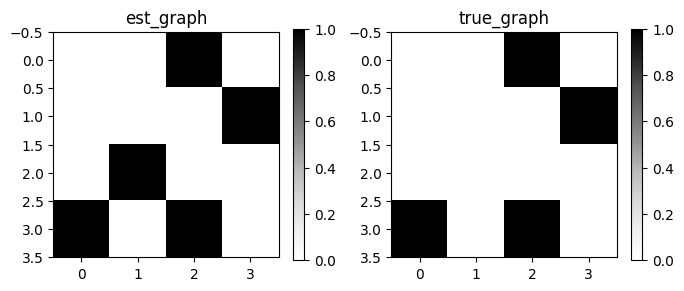

epoch:350 loss:5.6967 nll:5.6917 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|977 num_lr_updates:1


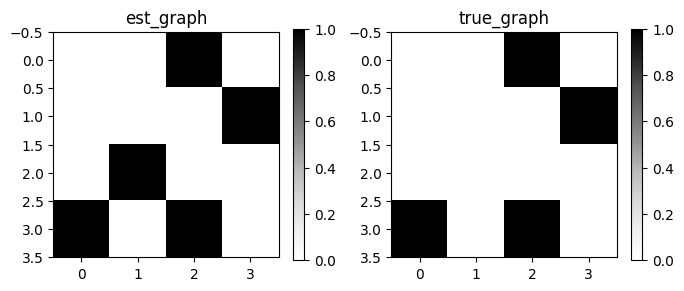

epoch:360 loss:5.6724 nll:5.6675 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|1077 num_lr_updates:1


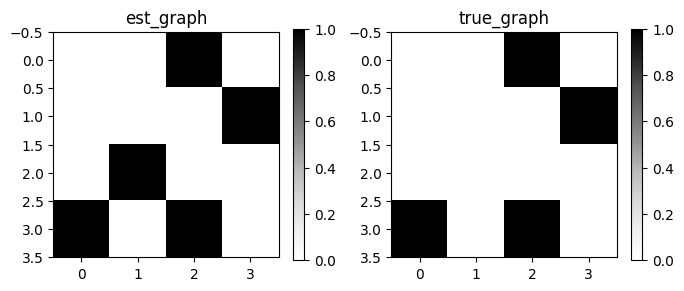

epoch:370 loss:5.6821 nll:5.676 dagness:1.18629 num_edges:6 alpha:0.67233 rho:1 step:1|1177 num_lr_updates:2


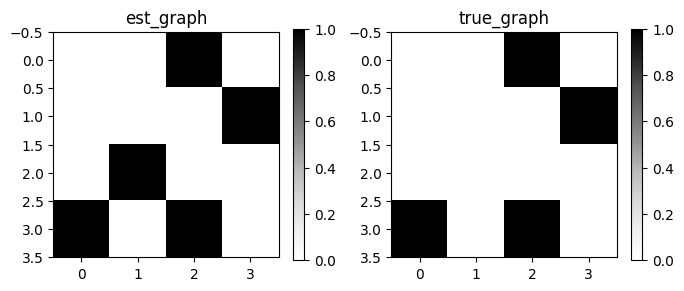

epoch:380 loss:5.6933 nll:5.6883 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|1277 num_lr_updates:2


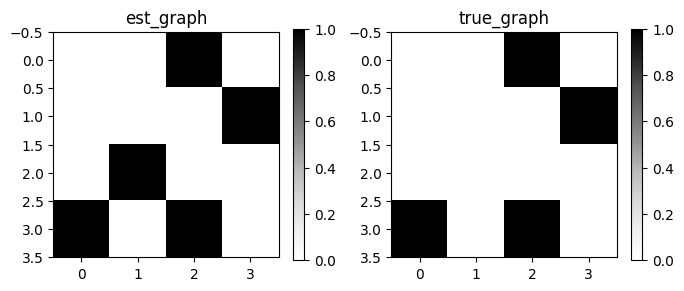

epoch:390 loss:5.7205 nll:5.7155 dagness:0.67233 num_edges:5 alpha:0.67233 rho:1 step:1|1377 num_lr_updates:2


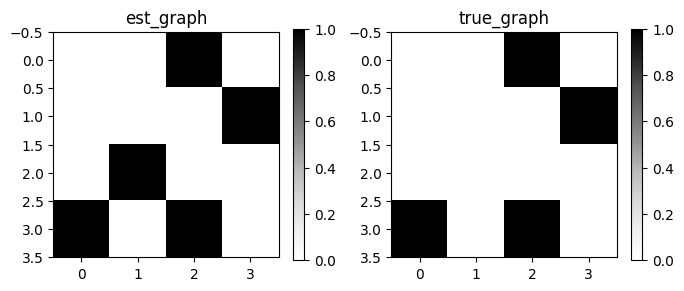

Updating rho, dag penalty prev:  0.6723327637
epoch:400 loss:5.6512 nll:5.6452 dagness:1.18629 num_edges:6 alpha:0.67233 rho:10 step:2|56 num_lr_updates:0


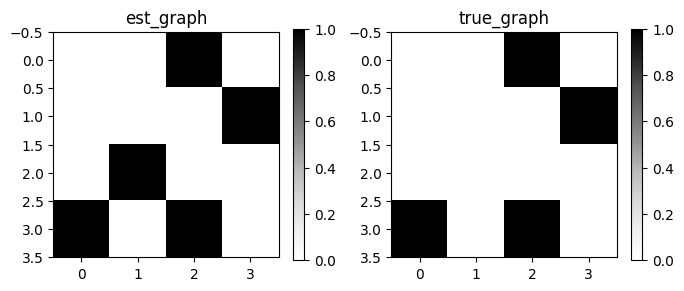

epoch:410 loss:5.7531 nll:5.7481 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|156 num_lr_updates:0


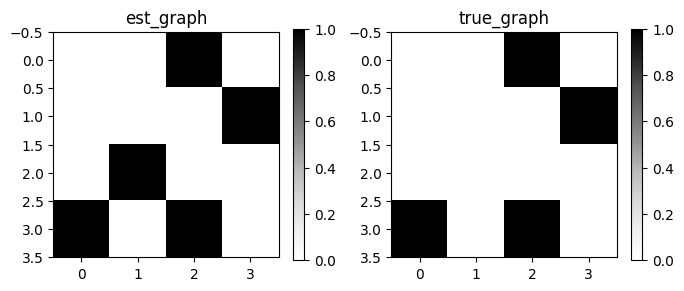

epoch:420 loss:5.611 nll:5.606 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|256 num_lr_updates:0


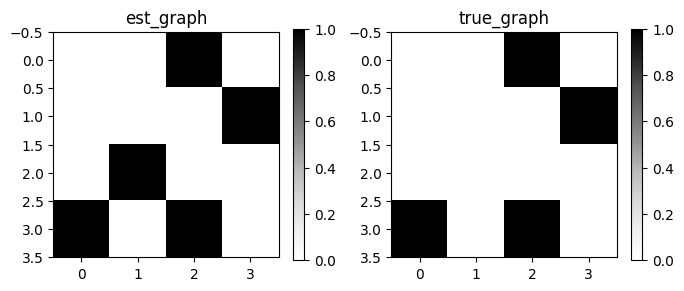

epoch:430 loss:5.7127 nll:5.7077 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|356 num_lr_updates:0


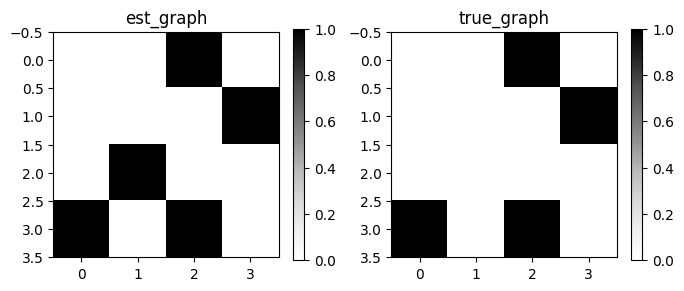

epoch:440 loss:5.5282 nll:5.5232 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|456 num_lr_updates:0


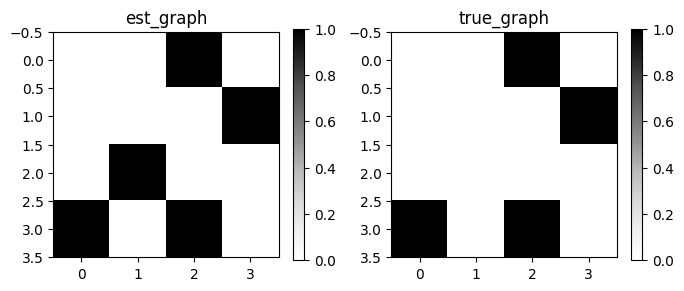

epoch:450 loss:5.5457 nll:5.5407 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|556 num_lr_updates:0


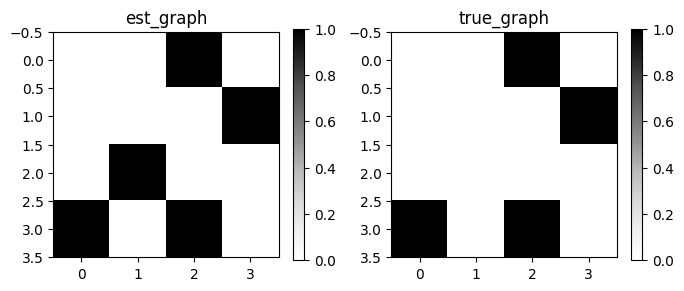

epoch:460 loss:5.6348 nll:5.6298 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|656 num_lr_updates:1


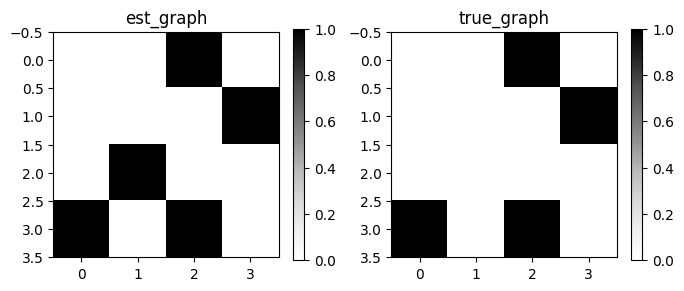

epoch:470 loss:5.6767 nll:5.6717 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|756 num_lr_updates:1


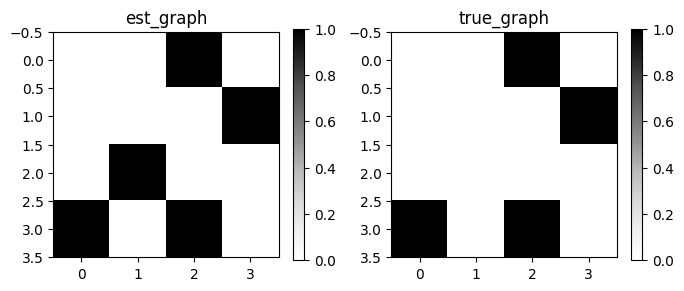

epoch:480 loss:5.7056 nll:5.7006 dagness:0.67233 num_edges:5 alpha:0.67233 rho:10 step:2|856 num_lr_updates:1


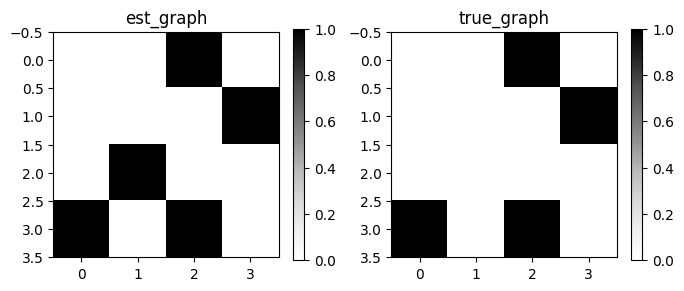

epoch:490 loss:5.6162 nll:5.6101 dagness:1.18629 num_edges:6 alpha:0.67233 rho:10 step:2|956 num_lr_updates:1


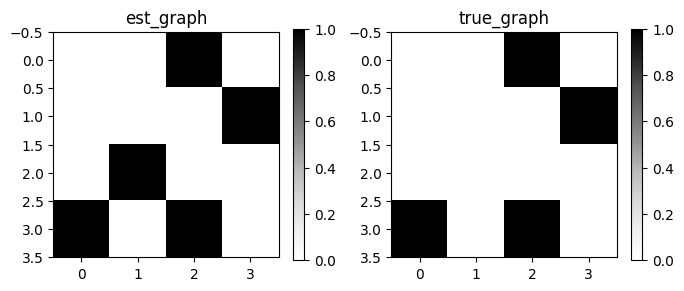

In [26]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"

num_samples = len(dataset_train)

for epoch in range(training_config.max_epoch):
    
    for i, batch in enumerate(dataloader_train):
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Get SEM 
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), 
            temperature=training_config.gumbel_temp
        )  # soft sample
        
        # Compute the log probability of data
        batch_log_prob = sem.log_prob(batch).mean()
        
        # Get the distribution entropy
        sem_distribution_entropy = sem_distribution.entropy()
        
        # Compute the likelihood of the current graph
        prior_term = prior.log_prob(sem.graph)
        
        # Compute the objective
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        
        # Compute the DAG-ness term
        constraint = calculate_dagness(sem.graph)
        
        # Compute the Lagrangian loss
        loss = auglag_loss(objective, constraint / num_samples)

        # Propagate gradients and update
        loss.backward()
        optimizer.step()
        
        # Update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss, #loss.item(),
            lagrangian_penalty=constraint #constraint.item(),
        )
        
        # Log metrics & plot the matrices
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )
            
            vardist = adjacency_dist()
            pred_dag = vardist.mode.cpu().numpy()

            plt.style.use('default')

            GraphDAG(
                est_dag=pred_dag, 
                true_dag=adj_matrix)

            plt.show()

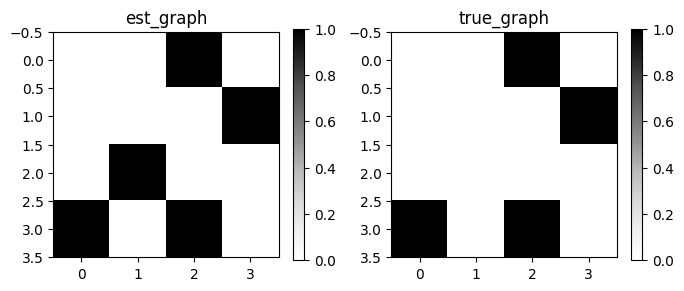

In [29]:
# Sample from the distribution of graphs
vardist = adjacency_dist()
pred_dag = vardist.mode.cpu().numpy()


# Plot the final graph vs the ground truth
plt.style.use('default')

GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [30]:
# Compute and print the metrics
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

metrics.metrics

{'fdr': 0.2,
 'tpr': 1.0,
 'fpr': 0.5,
 'shd': 1,
 'nnz': 5,
 'precision': 0.8,
 'recall': 1.0,
 'F1': 0.8889,
 'gscore': 0.75}

## Causal discovery under hidden confounding

In [32]:
%pip install causal-learn

  Using cached causal_learn-0.1.4.4-py3-none-any.whl.metadata (4.6 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
  Using cached pydot-4.0.1-py3-none-any.whl.metadata (11 kB)
  Using cached momentchi2-0.1.8-py3-none-any.whl.metadata (6.1 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached causal_learn-0.1.4.4-py3-none-any.whl (191 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)
Using cached momentchi2-0.1.8-py3-none-any.whl (11 kB)
Using cached pydot-4.0.1-py3-none-any.whl (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 6.8 MB/s  0:00:01m0:00:010:01m
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [causal-learn] [causal-learn]
Note: you may need to restart the kernel to use updated packages.


In [33]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge

/Users/oneshin/.pyenv/versions/3.10.18/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [34]:
# Generate confounded data
N = 1000

q = np.random.uniform(0, 2, N)
w = np.random.randn(N)
x = np.random.gumbel(0, 1, N) + w
y = 0.6 * q + 0.8 * w + np.random.uniform(0, 1, N)
z = 0.5 * x + np.random.randn(N)


data = np.stack([x, y, w, z, q]).T
confounded_data = np.stack([x, y, z, q]).T

In [35]:
# Create the true graph
nodes = ['X', 'Y', 'W', 'Z', 'Q']

edges = [
    ('W', 'X'),
    ('W', 'Y'),
    ('Q', 'Y'),
    ('X', 'Z'),
]

fci_graph = nx.DiGraph()

fci_graph.add_nodes_from(nodes)
fci_graph.add_edges_from(edges)

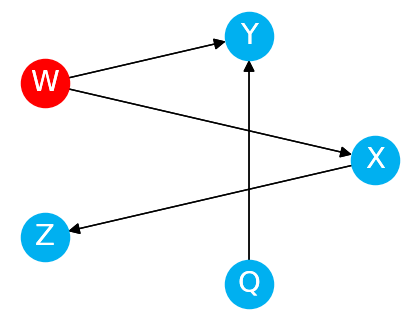

In [36]:
# Plot the graph
plt.figure(figsize=(4, 3))

nx.draw(
    G=fci_graph,
    node_color=COLORS[0],
    node_size=1200,
    nodelist=['X', 'Y', 'Z', 'Q'],
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(fci_graph)
)
nx.draw(
    G=fci_graph,
    node_color=COLORS[1],
    node_size=1200,
    nodelist=['W'],
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(fci_graph)
)

### Model 

In [37]:
# Train FCI and get the graph
g, edges = fci(
    dataset=confounded_data, 
    independence_test_method='kci'
)

Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 36.47it/s]


In [38]:
# Ordering: [x, y, z, q]
g.graph

array([[0, 2, 2, 0],
       [1, 0, 0, 1],
       [2, 0, 0, 0],
       [0, 2, 0, 0]])

In [39]:
mapping = {
    'X1': 'X',
    'X2': 'Y',
    'X3': 'Z',
    'X4': 'Q'
}

for edge in edges:
    mapped = str(edge)\
        .replace(str(edge.node1), mapping[str(edge.node1)])\
        .replace(str(edge.node2), mapping[str(edge.node2)])
    print(mapped)

X o-> Y
X o-o Z
Q o-> Y


In [40]:
str(edge), str(edge.node1)

('X4 o-> X2', 'X4')

### Model with prior knowledge

In [41]:
# Add prior knowledge
prior_knowledge = BackgroundKnowledge()
prior_knowledge.add_forbidden_by_node(GraphNode('X2'), GraphNode('X4'))
prior_knowledge.add_required_by_node(GraphNode('X1'), GraphNode('X3'))

g, edges = fci(
    dataset=confounded_data, 
    independence_test_method='fisherz',
    background_knowledge=prior_knowledge
)

Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 574.70it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X4 --> X2
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X4 --> X2
Finishing BK Orientation.


In [42]:
for edge in edges:
    mapped = str(edge)\
        .replace(str(edge.node1), mapping[str(edge.node1)])\
        .replace(str(edge.node2), mapping[str(edge.node2)])
    print(mapped)

X o-> Y
X --> Z
Q --> Y
